In [1]:
# FILE RENAME SCHEME CODE:
# import os
# #rename physiq filenames:
# folder = "raw_datasets/PHYSIQ_copy/"
# filelabels = []
# for filename in os.listdir(folder):
#     if filename.endswith(".csv"):
#         filelist = filename.split("_")
#         pair = (filelist[1], int(filelist[3]))
#         if pair not in filelabels:
#             filelabels.append(pair)

# # sort by first then sec in pair:
# filelabels.sort(key=lambda x: (x[0], x[1]))

# # how to get index of filelabel (dict):

# print(filelabels)
# print(len(filelabels))
# for filename in os.listdir(folder):
#     if filename.endswith(".csv"):
#         filelist = list(filename.split("_"))
#         print(filelist)
#         filelist[1] = str(filelabels.index((filelist[1], int(filelist[3]))))
#         filelist.pop(3)
#         filelist.pop(3)
#         newname = "_".join(filelist) + '.csv'
#         print(filelist, newname)
#         os.rename(folder+filename, folder+newname)

In [1]:
import os
import numpy as np
import pandas as pd
import torch
            

In [2]:

def generate_data( directory, window_size=75, step_size=32, pick_one=1, range=(0, 6)):
    from utilities import sliding_windows
    sw = sliding_windows(window_size, step_size)
    label_maps = []
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            if filename.split("_")[1] not in label_maps:
                label_maps.append(filename.split("_")[1])
    print(len(label_maps))
    assert pick_one < len(label_maps), "pick_one is out of range"
    save_data = []
    save_label = []
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            data = pd.read_csv(directory+filename)
            data_np = data.to_numpy()[:, range[0]:range[1]]
            if pick_one >= 0:
                if filename.split("_")[1] != label_maps[pick_one]:
                    cls = 0
                else:
                    cls = 1
            else:
                cls = label_maps.index(filename.split("_")[1])
            label = np.array([cls] * data_np.shape[0])
            data_windows, label_windows = sw.forward(torch.tensor(data_np), labels=torch.tensor(label))
            save_data.append(data_windows)
            save_label.append(label_windows)
    save_data = torch.cat(save_data)
    save_label = torch.cat(save_label)
    return save_data, save_label
            
            
            

In [3]:
# custom Dataset:
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, data, label, transform=None):
        self.data = data
        self.label = label
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.data[idx]), self.label[idx]
        return self.data[idx], self.label[idx]

In [4]:
from utils_loader import MultiEpochsDataLoader
from sklearn.discriminant_analysis import StandardScaler
import torch
from utilities import seed

class StandardTransform(torch.nn.Module):
    def __init__(self, scaler='standard'):
        super(StandardTransform, self).__init__()
        if scaler == 'standard':
            self.scaler = StandardScaler()
        else:
            raise NotImplementedError('Only standard scaler is implemented')
        
    def __call__(self, data):
        data = self.scaler.transform(data)
        return torch.tensor(data)
    
    def fit(self, data):
        n_samples, n_time_steps, n_features = data.shape
        data_reshaped = data.reshape(-1, n_features)  # The shape becomes (n_samples * n_time_steps, n_features)
        self.scaler.fit(data_reshaped)
        print('Fitted with mean: {}, and std: {}'.format(self.scaler.mean_, np.sqrt(self.scaler.var_)))
        return self
    

seed(73054772)
directory = './raw_datasets/SPAR/'

# create train, val, test dataset:
segmented_samples, segmented_labels = generate_data(directory, window_size=100, step_size=50, pick_one=-1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(segmented_samples, segmented_labels, test_size=0.3, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle=True)

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

d, l = next(iter(train_loader))

7


In [5]:
from segmenter import Segmenter
from utilities import get_device
device = get_device()

MPS is available.


In [6]:
def mean_iou_time_series(pred, gt, num_classes=7):
    """
    Calculate the Mean Intersection over Union (mIoU) for time series data.
    
    Parameters:
        pred (torch.Tensor): Predictions, assumed to be one-hot encoded.
        gt (torch.Tensor): Ground truth labels, assumed to be one-hot encoded.
        num_classes (int): Number of classes in the segmentation task.

    Returns:
        float: Mean IoU for the batch.
    """
    # Initialize variables to store IoU for each class
    iou_list = []

    # Loop through each class
    for cls in range(num_classes):
        pred_inds = pred == cls
        gt_inds = gt == cls

        # Calculate Intersection and Union
        # print(pred_inds.shape, gt_inds.shape)
        intersection = torch.sum(pred_inds & gt_inds, dim=1).float()
        union = torch.sum(pred_inds | gt_inds, dim=1).float()

        # Calculate IoU. Avoid division by zero by adding a small epsilon.
        iou = intersection / (union + 1e-8)

        # Append the mean IoU for this class
        iou_list.append(torch.mean(iou))

    # Calculate the mean IoU across all classes
    mean_iou = torch.mean(torch.stack(iou_list))

    return mean_iou.item()


def mean_iou(preds, labels, num_classes):
    # Flatten the predictions and labels, this comes from the argmax of the one-hot vectors
    preds = preds.view(-1)
    labels = labels.view(-1)

    # Create confusion matrix
    confusion_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int64)
    for i in range(num_classes):
        for j in range(num_classes):
            confusion_matrix[i, j] = torch.sum((preds == i) & (labels == j))

    # Calculate IoU for each class
    ious = []
    for i in range(num_classes):
        true_positive = confusion_matrix[i, i]
        false_positive = confusion_matrix[i, :].sum() - true_positive
        false_negative = confusion_matrix[:, i].sum() - true_positive

        # Avoid division by zero
        union = true_positive + false_positive + false_negative
        if union == 0:
            ious.append(float('nan'))  # No predictions and no labels for this class
        else:
            ious.append(true_positive.float() / union.float())

    # Calculate mean IoU
    ious = torch.tensor(ious)
    mean_iou = torch.nanmean(ious)  # Mean over all classes, ignoring NaNs
    return mean_iou


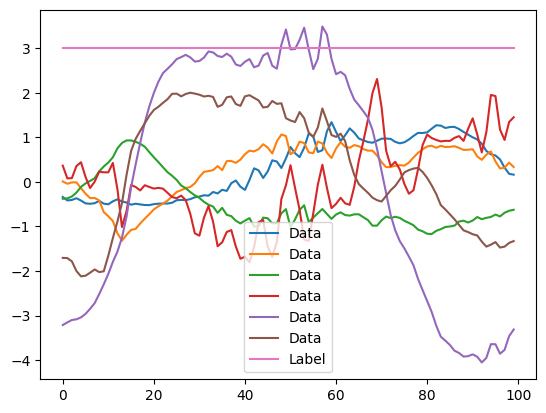

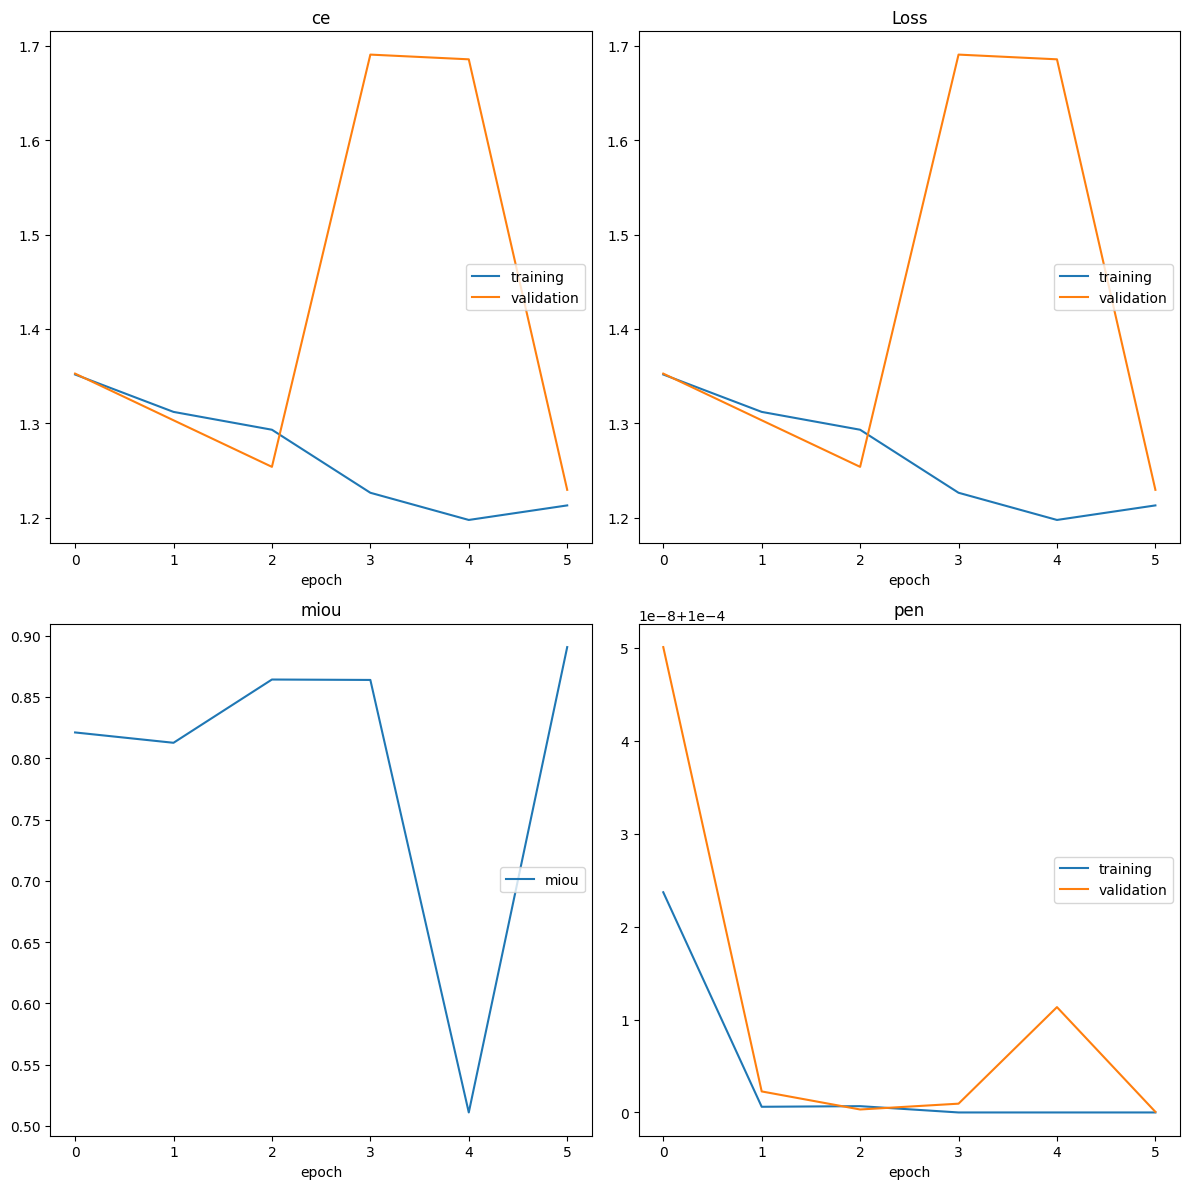

ce
	training         	 (min:    1.198, max:    1.352, cur:    1.213)
	validation       	 (min:    1.229, max:    1.691, cur:    1.229)
Loss
	training         	 (min:    1.198, max:    1.352, cur:    1.213)
	validation       	 (min:    1.229, max:    1.691, cur:    1.229)
miou
	miou             	 (min:    0.511, max:    0.891, cur:    0.891)
pen
	training         	 (min:    0.000, max:    0.000, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)


In [7]:
# Create an instance of the CNN model
from livelossplot import PlotLosses
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
from utilities import get_device
num_epochs = 100 
def c_loss(logits):
    probabilities = F.softmax(logits, dim=1)
    one_hot_predictions = torch.argmax(probabilities, dim=1)
    product_prob = torch.prod(probabilities, dim=1)
    changes = torch.abs(one_hot_predictions[:, 1:]*product_prob[:, 1:] - one_hot_predictions[:, :-1]*product_prob[:, :-1])
    penalty = changes.sum(dim=1).float().mean()
    return penalty + 1e-4
def custom_loss(logits, targets, penalty_weight=0.1):
    """
    Custom loss function that penalizes frequent changes in the prediction sequence.
    
    Args:
    - logits: Tensor of shape [N, C, L], where N is batch size, C is number of classes, and L is sequence length.
    - targets: Tensor of shape [N, L] containing class indices for each element in the sequence.
    - penalty_weight: Weight of the penalty term.

    Returns:
    - Total loss with the penalty.
    """

    # Standard cross-entropy loss
    probabilities = F.softmax(logits, dim=1)
    ce_loss = F.cross_entropy(probabilities, targets)

    penalty = c_loss(logits)
    total_loss = ce_loss #penalty * penalty_weight

    return total_loss, ce_loss.item(), penalty.item()

def plotASample(data, label):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)  # Add a new subplot to the figure
    ax.plot(data, label='Data')  # Plot the data
    ax.plot(label, label='Label')  # Plot the label
    ax.legend()  # Add a legend
    fig.canvas.draw()  # Redraw the figure
    plt.plot()


model = Segmenter().to(device)

# Define the loss function and optimizer
criterion = custom_loss #nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.00)
liveloss = PlotLosses()

# Iterate over the training data
logs = {}
# change the plt size:
best_loss = math.inf
counter_i = 0
for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Forward pass
        images = images.float().to(device)
        labels = labels.to(device)
        outputs = model(images)
        outputs = outputs.permute(0, 2, 1)
        loss, tra_ce, tra_pen = criterion(outputs, labels.long())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # train loss and accuracy check:
        if counter_i % 1000 == 0 and counter_i != 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
            _, predicted = torch.max(outputs.data, 1)
            # total = labels.size(0)
            # correct = (predicted == labels).sum().item()
            # print('Accuracy: {:.2f}%'.format(correct / total * 100))
            logs['loss'] = loss.item()
            logs['ce'] = tra_ce
            logs['pen'] = tra_pen
            # logs['accuracy'] = correct / total * 100
    
            # validation loss and accuracy check:
            correct = 0
            total = 0
            for images, labels in val_loader:
                images = images.float().to(device)
                labels = labels.to(device)
                outputs = model(images)
                outputs = outputs.permute(0, 2, 1) #view(images.shape[0], 2, -1)
                loss, val_ce, val_pen = criterion(outputs, labels.long())
            logs['val_loss'] = loss.item()
            logs['val_ce'] = val_ce
            logs['val_pen'] = val_pen
            logs['miou'] = mean_iou(model.forward_pred(images), labels.long(), num_classes=7)
            if best_loss > loss.item():
                best_loss = loss.item()
                torch.save(model.state_dict(), './saved_model/best_transformer_spar.pth')
            pred = torch.argmax(torch.softmax(outputs[0], dim=0), dim=0).detach().cpu().numpy()
            plotASample(images[0].detach().cpu().numpy(), pred)
            liveloss.update(logs)
            liveloss.send()
            # logs['val_accuracy'] = correct / total * 100
        counter_i += 1


In [7]:
import time
from matplotlib import pyplot as plt
from IPython.display import display, clear_output
import torch


model = Segmenter().to(device)
model.load_state_dict(torch.load('./saved_model/best_transformer_spar.pth', map_location=device))

model.eval()
miou, total = 0, 0
with torch.no_grad():
    for data, label in test_loader:
        data = data.float().to(device)
        label = label.squeeze().long().to(device)
        output = model.forward_pred(data)
        # print(output.shape, label.shape)
        # print(output[0], label[0])
        miou += mean_iou(output, label, 7)
        total += 1
        
        # print('output', output)])
        # plt.plot(data[0].view(-1, 6).cpu().numpy(), color='black')
        # plt.plot(output[0].view(-1).detach().squeeze().cpu().numpy(), color='green')
        # plt.plot(label[0].view(-1).cpu().numpy(), color='red')
        # plt.show()
        # # wait for 1 sec:
        # time.sleep(1)
        # erase the output:
        # clear_output(wait=True)

print('mIoU coefficient:', miou / total)

mIoU coefficient: tensor(0.9113)


# Attempt to do FSL on segmentation, we treating each embedding in t as a proabbilities distribution

In [30]:
# few show learning on a new dataset:
directory = './raw_datasets/SPAR/'

# create segmented samples
segmented_samples, segmented_labels = generate_data(directory, window_size=100, step_size=50, pick_one=-1,)
proc_segmented_samples = []
proc_segmented_labels =[]
print(len(segmented_samples), len(segmented_labels))
for ss, sl in zip(segmented_samples, segmented_labels):
    if sl[0] <= 6:
        proc_segmented_samples.append(ss)
        proc_segmented_labels.append(sl)
print(len(proc_segmented_samples), len(proc_segmented_labels))

# split the dataset:
X_train, X_test, y_train, y_test = train_test_split(proc_segmented_samples, proc_segmented_labels, test_size=0.3, random_state=42, shuffle=True)


7
11767 11767
11767 11767


In [31]:
# get samples for each class:
samples = []
labels = []
label_flag = [0]*7
for s, l in zip(X_train, y_train):
    if label_flag[l[0]] < 1:
        samples.append(s)
        labels.append(l)
        label_flag[l[0]] += 1
    else:
        continue
samples = torch.stack(samples)
labels = torch.stack(labels)



test_samples = []
test_labels = []
label_flag = [0]*7
for s, l in zip(X_test, y_test):
    if label_flag[l[0]] < 1:
        test_samples.append(s)
        test_labels.append(l)
        label_flag[l[0]] += 1
    else:
        continue
test_samples = torch.stack(test_samples)
test_labels = torch.stack(test_labels)

In [32]:

model.eval()
patch, cls_seg_feat = model.get_embedding(samples.float().to(device))
mask = model(samples.float().to(device))
patch_0 = patch[0].squeeze().detach().cpu().numpy()
patch.shape, cls_seg_feat.shape, mask.shape

(torch.Size([7, 100, 256]), torch.Size([7, 7, 256]), torch.Size([7, 100, 7]))

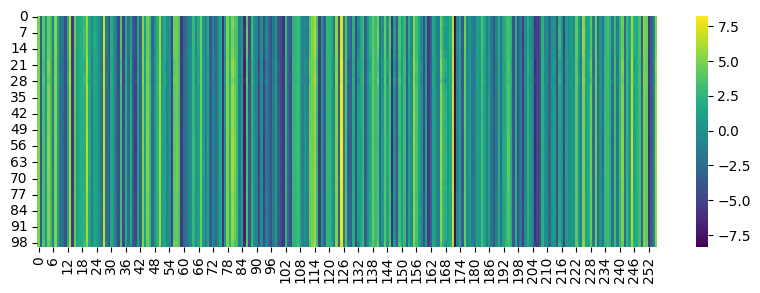

In [33]:
# use the patch embedding of the first sample to visualize the attention:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
# plot the cls_seg_feat:
plt.figure(figsize=(10, 3))
sns.heatmap(patch_0, cmap='viridis')
plt.show()



is torch.Size([1, 256])
is torch.Size([1, 256])
is torch.Size([1, 256])
is torch.Size([1, 256])
is torch.Size([1, 256])
is torch.Size([1, 256])
is torch.Size([1, 256])
z_proto torch.Size([7, 1, 256])
torch.Size([7, 100, 256])
scores torch.Size([7, 100])


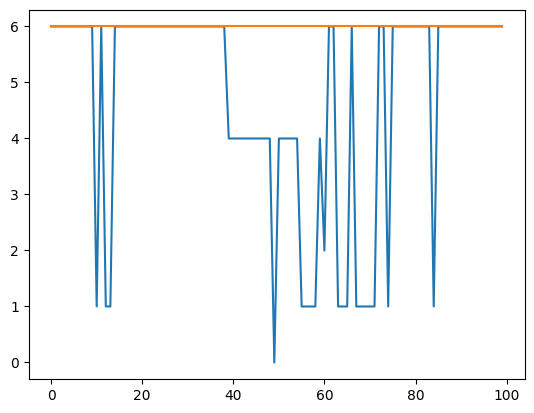

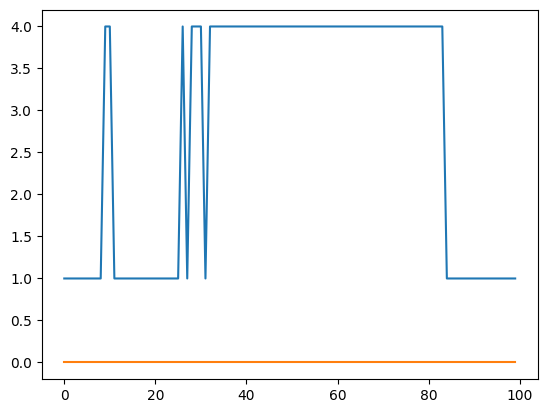

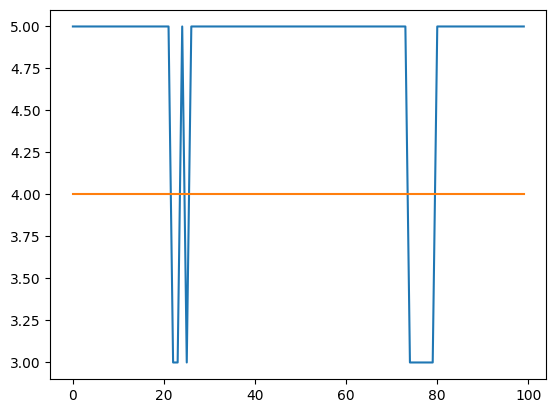

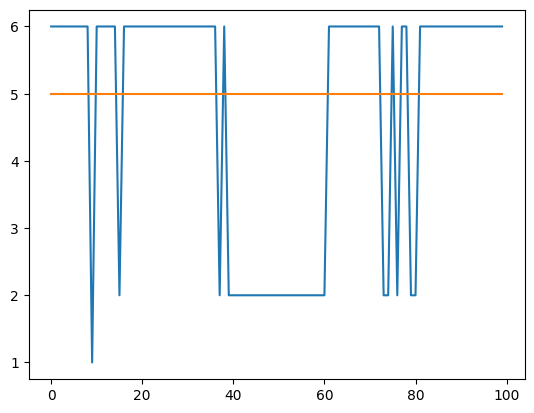

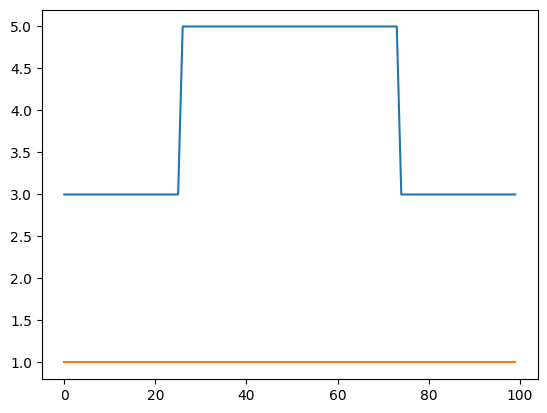

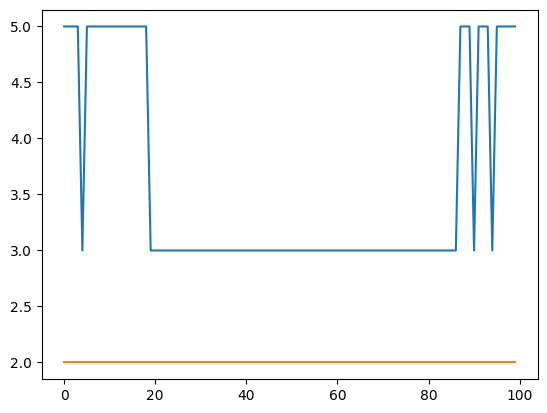

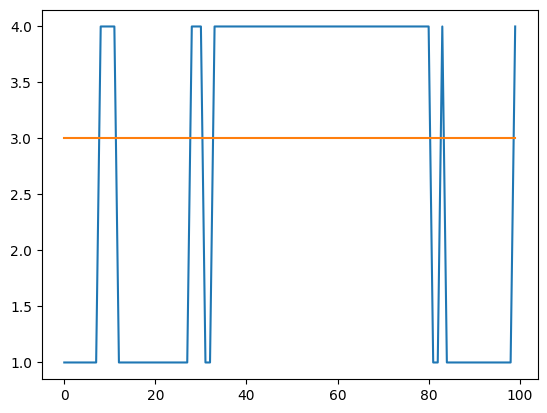

tensor(0.0546)

In [73]:
#TODO: not finished yet on how to get this done: getting the distribution of the same labels for all the samples, 
# then compare against query sample so that we can use it as a transductive method to predict the label of the query sample at t.

# placeholder = []
# for _ in range(7):
#     placeholder.append([])
    
# for each_sample, each_label in zip(patch, labels):
#     for i in range(each_label.shape[0]):
#         placeholder[each_label[i]].append(each_sample[i].detach().cpu().numpy())
    

# for i in range(7):
#     placeholder[i] = np.array(placeholder[i])
#     print(placeholder[i].shape)
#     plt.plot(placeholder[i].mean(axis=0), label=str(i))
model.eval()
patch_query, cls_seg_feat = model.get_embedding(test_samples.float().to(device))
mask = model(samples.float().to(device))
n_way = 7
############ https://github.com/slei109/PATNet/blob/1d4c93343e4d18d2b2c8ffa4b3a9665da4dfac23/model/patnet.py#L165
def forward_shot_max(anchor_img, pos_img_list, pos_mask_list):
    outB_side_list = []
    for i in range(1):
        pos_img = pos_img_list[i]
        pos_mask = pos_mask_list[i]

        outA_pos, _ = netB(pos_img)

        _, _, mask_w, mask_h = pos_mask.size()
        outA_pos = F.upsample(outA_pos, size=(mask_w, mask_h), mode='bilinear')
        vec_pos = torch.sum(torch.sum(outA_pos*pos_mask, dim=3), dim=2)/torch.sum(pos_mask)

        outB, outB_side = self.netB(anchor_img)

        # tmp_seg = outB * vec_pos.unsqueeze(dim=2).unsqueeze(dim=3)
        vec_pos = vec_pos.unsqueeze(dim=2).unsqueeze(dim=3)
        tmp_seg = self.cos_similarity_func(outB, vec_pos)

        exit_feat_in = outB_side * tmp_seg.unsqueeze(dim=1)
        outB_side_6 = self.classifier_6(exit_feat_in)
        outB_side = self.exit_layer(outB_side_6)

        outB_side_list.append(outB_side)

    return outB, outA_pos, vec_pos, outB_side_list